# Tutorial 2: Building a first model

In tutorial 1, we got a basic understanding of our problem. We learned that the images show over 1000 different whales. For the majority of them exists only a single image. 
We also considered the score function that determins the placings on the leaderboard. Recall that our task is:

**For every image *i* in the *test_val* folder, predict the 20 images that are most similar to *i*.**

In this tutorial, we will build two solutions to this problem. Let's get started!

### Table of contents

[1. Similarity between Images](#section1) <br>
[2. A bit of history: The ImageNet Challenge](#section2) <br>
&emsp; [2.1 What is a Deep Learning Model for image classification](#section2.1) <br>
[3. On the shoulders of giants: Using pretrained model to convert images](#section3) <br>
[4. How to measure similarity](#section4) <br>
[5. Our baseline](#section5) <br>
[6. Learn, don't define: A better similarity measure](#section6) <br>
&emsp; [6.1 Examples for the AI: Creating image pairs ](#section6.1) <br>
&emsp; [6.2 Feeding examples to the AI ](#section6.2) <br>
&emsp; [6.3 Defining the model ](#section6.3) <br>
&emsp; [6.4 Training the model ](#section6.4) <br>
&emsp; [6.5 Creating predictions  ](#section6.5) <br>


In [1]:
# For readability, we list all libraries we use in this notebook at the beginning
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from matplotlib.pyplot import imshow
from pathlib import Path
from itertools import combinations
#from src.data.process_dataset import DataGeneratorFromEmbeddings
from src.src_data_process_dataset import DataGeneratorFromEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'src.src_data_process_dataset'

<a id='section1'></a>
# Similarity between images

What makes two images similar? The colors? The shapes that appear? If you were to write an algorithm for it, how would you even start?

Let's start by considering how a machine sees a picture. For a computer, an image is essentially a 3-d matrix. Take for example one of our whale fluke images:

<a id='section3'></a>
## On the shoulders of giants: Using pretrained model to convert images

As described in the previous section, pre-trained deep learning models allow us to convert an image to a vector of size 1024 that contains the relevant information in the image. In this section, you'll learn how to do this.

We'll use a model called [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) that was trained on the ImageNet dataset for a first test. MobileNet is a second generation model that trades accuracy for speed. I.e. the vector representation will not be the best, but it will run on our laptops.
In the next tutorial we will show you how to use AWS to take advantage of [more advanced models](https://keras.io/applications/) and even train your own models.

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

TRAIN_PATH = '../experiments/12. contour_edge_Li_tilt_noscaling_hsv-filter/train/'
TEST_PATH = '../experiments/12. contour_edge_Li_tilt_noscaling_hsv-filter/test-val/'
OUT_FILE = '../experiments/12. contour_edge_Li_tilt_noscaling_hsv-filter/' + 'siamese_li_edge_tilt_hsv_noscale_hsv-filter.csv'

#TRAIN_PATH = '../data/train/'
#TEST_PATH = '../data/test_val/'
#OUT_FILE = './siamese_distance_only_preds_no-1.csv'

model = MobileNet(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

The options *include_top=False* and *pooling='avg'* are necessary to extract the *logits* layer. 
The *input_shape* defines the size of the images. The default for ImageNet models is 224x224 pixels with 3 channels for colors.
We can check out the architecture of the model with the *summary* function.

<a id='section5'></a>
## Our baseline model

Now that we are aware of the concept, we are one step closer to our first submission. We will 

- use Mobilenet to compute the embeddings for all of the train and test pictures 
- calculate the cosine similarity between each of the embeddings of the test pictures and the embeddings of the train pictures
- create a submission that predicts the 20 matches with the highest similarity score

We start with loading all pictures with [Tensorflow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).As first step we are going to list all file paths and names.

In [3]:
train_data_path = Path(TRAIN_PATH)
train_files_paths = list(train_data_path.glob('*/*.jpg'))  # All file paths

###### MY IMPLEMENTATION: Remove class -1
train_files_paths_filtered = []
for file_path in train_files_paths:
    if not('\\-1\\' in str(file_path)):
        train_files_paths_filtered.append(file_path)
train_files_paths = train_files_paths_filtered
###### Back to Tutorial 2 #########

train_files_names = [p.name for p in train_files_paths]  # Only the file names without the full path
train_files_classes = [p.parent.name for p in train_files_paths]  # The parent directory, i.e. the whale ID, for each image

test_data_path = Path(TEST_PATH)
test_files_paths = list(test_data_path.glob('*.jpg'))
test_files_names = [p.name for p in test_files_paths]

In [4]:
len(train_files_paths)

3956

To load a single picture we have to read the file, convert it into a [tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor) object, adjust the size and standardize it to the MobileNet input format.

In [5]:
BATCH_SIZE = 32

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  # Resize image to 224x224 pixels
    img = preprocess_input(img)  # Do additional preprocessing that is required for MobileNet
    return img

Now that we have defined the prerequisites to load a single picture, we can apply it to all of our pictures. We create a dataset from our input data paths and apply the defined function to each entry in the dataset.

The batch size specifies the number of examples we use in one iteration of calcuation. For now you can ignore it. It will become more relevant later.

In [6]:
train_files = tf.data.Dataset.from_tensor_slices(list(map(str, train_files_paths)))  # Convert paths to strings
train_ds = train_files.map(load_image)  # Apply the load_image function to every image
train_ds = train_ds.batch(BATCH_SIZE)  # Set the batch size

test_files = tf.data.Dataset.from_tensor_slices(list(map(str, test_files_paths)))
test_ds = test_files.map(load_image)
test_ds = test_ds.batch(BATCH_SIZE)

To calculate the embeddings we use the Mobilenet. This will take a while, so time to grab a coffe while this is running :) 

In [7]:
%%time
embed_train = model.predict(train_ds)
embed_test = model.predict(test_ds)

Wall time: 5min 24s


In [8]:
print(f'Shape of training embeddings {embed_train.shape}')
print(f'Shape of test embeddings {embed_test.shape}')

Shape of training embeddings (3956, 1024)
Shape of test embeddings (808, 1024)


For every picture we have now the representation as a vector with a size of 1024. We can calculate the cosine similarity between all of them.

In [9]:
all_names = np.concatenate((train_files_names, test_files_names))  # Combine the train and test data
all_paths = np.concatenate((train_files_paths, test_files_paths))
embed_all = np.concatenate((embed_train, embed_test))
print(f'Shape of all embeddings {embed_all.shape}')

Shape of all embeddings (4764, 1024)


In [10]:
similarity_matrix = cosine_similarity(embed_test, embed_all)
print(f'Shape of the similarity matrix {similarity_matrix.shape}')

Shape of the similarity matrix (808, 4764)


For each of the 808 pictures in the test dataset we have the similarity to each of the 5340 other picutres. Let us take a look at one example.

In [11]:
index_1 = 666
index_2 = 2656
print(f'The cosine similarity of picture {index_1} and {index_2} is {similarity_matrix[index_1, index_2]}')

The cosine similarity of picture 666 and 2656 is 0.7585594654083252


And also at the two respective pictures

In [12]:
def show_images(img_paths):
    plt.figure(figsize=(30, 30))
    image_count = len(img_paths)
    for path, n in zip(img_paths, range(image_count)):
        ax = plt.subplot(image_count, 4, n + 1)
        img = load_img(path)
        plt.imshow(img)
        plt.title(f'{path.name}, class: {path.parent.name}')

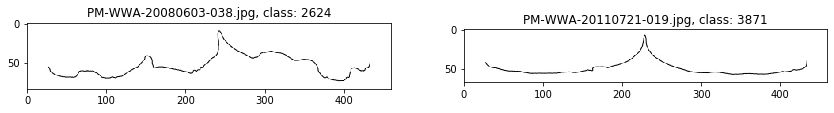

In [13]:
show_images([all_paths[index_1], all_paths[index_2]])

To create a submission, we sort the similarities in descending order and write the twenty most similar pictures in to a file. We use the [np.argsort](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html) function, which will return the indices to sort our matrix column-wise in ascending order. Since we want to have the direction descending, we will put a **-** before the similarity matrix.

In [14]:
indices = np.argsort(-similarity_matrix, axis=1)

Recall that the format for a submissions is

*test_pic, predicted_pic_1, predicted_pic_2, ...., predicted_pic_20*

The cosine similarity between a picture and itself is always 1.0. Hence the most similar image is always the image itself and we can create a submission as follows:

In [15]:
#with open('cosine_preds.csv', 'w') as f:
#    for i in range(len(test_files_names)):
#        indices_of_top_predictions = indices[i,:21]  # Get the indices of the 21 most similar images
#        names_of_top_predictions = all_names[indices_of_top_predictions]  # Get the file names of the 21 most similar images
#        preds = ','.join(names_of_top_predictions)  # Put a , between the image names
#        f.write(preds + '\n')  # Write it in a new line

When we upload the submission we get a score of *83.00*. 

<font color='blue'>

**Best practice:** 
- Deep Learning models are state-of-the-art for almost every image-type problem
- You can use pretrained models to compress the data in an image
- The cosine is an good baseline for similarity between vectors
- When tackling an AI problem, always start with a simple model. This is called the baseline model

<a id='section6'></a>
# Learn, don't define: A better similarity measure

The baseline model took existing concepts and applied them to our problem. In other words, we took a standard software-engineering approach. The drawback of this approach is that that we have to manually define every single step. 

Now let us solve the problem with artificial intelligence, or rather machine learning. Here's the battle plan:

- Goal: Our model should learn whether or not two images show the same whale.
- Data: Create a dataset of images pairs and a label that denotes if the two images show the same whale.
- Architecture: A [Siamese Twin Network](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) fits perfectly to our use case

![siamese](https://miro.medium.com/max/1531/1*dFY5gx-Vze3micJ0AMVp0A.jpeg)

As the image illustrates, a Siamese Twin Network 

- takes two images as input
- embeds them via a convolutional neural network
- computes the absolute difference between the two embeddings
- predicts whether or not the images are equal based on the difference.

Note that our baseline model is very similar to the siamese twin approach. We computed embeddings with MobileNet and instead of learning the similarity from the absolute difference of the embeddings we used the cosine similarity.

*For our next model, we'll keep the MobileNet embeddings and replace the cosine similarity with a learned distance function.*

<font color='blue'>
    
**Best practice:** 
    
- Create an architecture image to illustrate and discuss deep learning models
- Learn the different types of layers and when to use them

<a id='section6.1'></a>
## Examples for the AI: Creating image pairs 

For the input we need to create pairs of images with a label that is *1* if the images show the same whale and *0* if the images show a different whale. First we create pairs of images with the [combinations](https://stackoverflow.com/questions/942543/operation-on-every-pair-of-element-in-a-list) function.

**Exercise:** Read up on how exactly the *combinations* works. Is this the best way to create image pairs? 

In [15]:
train_pairs = list(combinations(zip(train_files_names, train_files_classes), 2))

*train_pairs* consists of tuples where the first entry is the name of the file and the second the corresponding class. E.g.

In [16]:
train_pairs[0]

(('PM-WWA-20160724-126.jpg', '0161'), ('PM-WWA-20150426-061.jpg', '0836'))

Now we can add the information about the similarity. Two images are similar [iff](https://en.wikipedia.org/wiki/If_and_only_if) they have the same class.

In [17]:
def is_similar(pair):
    image_one_class = pair[0][1]
    image_two_class = pair[1][1]
    if image_one_class == image_two_class:
        return 1
    else:
        return 0

In [18]:
train_labels = {pair: is_similar(pair) for pair in train_pairs}

In the example pair from above, both images have the class *-1*. Hence the corresponding label is *1*.

In [19]:
# How many pairs are there?
total_pairs = len(train_pairs)
matched_pairs = sum(x == 1 for x in train_labels.values())
unmatched_pairs = sum(x == 0 for x in train_labels.values())
print("{} pairs. {} matched pairs ({}%); {} unmatched pairs ({}%)".format(total_pairs,matched_pairs,round(matched_pairs/total_pairs,4)*100,unmatched_pairs,round(unmatched_pairs/total_pairs,4)*100))

7822990 pairs. 7044 matched pairs (0.09%); 7815946 unmatched pairs (99.91%)


In [20]:
sum(x == 1 for x in train_labels.values())

7044

In [21]:
len(train_files_names)

3956

<a id='section6.2'></a>
## Feeding examples to the AI
Now we have all the information we need and we can start loading the pictures. Since the size of our data might not fit into RAM all at once, we are using the [DataGenerator](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) class that Keras offers. The DataGenerator class continuously loads our data during the training process.
In order to do modelling, we have to define on which data our model can train on. 

In [22]:
train_embeddings = {img: embedding for img, embedding in zip(train_files_names, embed_train)}

To speed up the computations, we create a dictionary, i.e. a lookup table, that given the name of a image file returns the precomputed embedding. Together with the pairs and labels we created in the previous section, we can create our own *DataGenerator*.
The details will be covered in the next tutorial. If you can't wait, the source code lies in *src.data.process_dataset.py*.

In [23]:
train_generator = DataGeneratorFromEmbeddings(train_pairs, train_embeddings, train_labels)

A *DataGenerator* creates tupels of inputs (i.e. embeddings) and expected outputs (i.e. labels) that we can use to train our model. Let us take a look on one example. Per default, one sample consists of 32 embeddings and labels.

In [24]:
embeddings, labels = train_generator.get_sample(0)
print(f'The loaded pictures are in shape {embeddings[0].shape}')
print(f'The loaded labels are in shape {labels.shape}')

The loaded pictures are in shape (32, 1024)
The loaded labels are in shape (32,)


<font color='blue'>
    
**Best practice:** 
    
- Use a DataGenerator to feed data into your model. 
- Deep Learning uses a lot of resources. Precomputing and caching data can save a lot of time.
- Split the data into a [train and validation subset](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets) to evaluate the performance of your model during the training.

**Exercise:** Split the data into train and test set.

<a id='section6.3'></a>
## Defining the model
The next step in our process is the turn the image into an actual model. The following code defines a model that implements the siamese twin network shown above and compiles it.

*Note: Usually, you do not need to compile Python code. Tensorflow models are an exception since they are focussed on performance.*

In [25]:
EMBED_LENGTH = 1024

def model_mobilenet_fn(learning_rate):    
    """
    Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    input_shape = [EMBED_LENGTH]
    embeddings_1 = Input(input_shape)
    embeddings_2 = Input(input_shape)

    # Add a customized layer to compute the absolute difference between the encodings 
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    absolute_difference = L1_layer([embeddings_1, embeddings_2])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    similarity_score = Dense(1, activation='sigmoid', 
                       bias_initializer=RandomNormal(mean=0.5, stddev=0.01, seed=None))(absolute_difference)
    
    siamese_net = Model(inputs=[embeddings_1,embeddings_2], outputs=similarity_score)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return siamese_net

To create an actual instance of the model, we only need to specify the [learning rate](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10). The *summary* function gives an overview of our creation.

In [26]:
learning_rate = 0.0001
#learning_rate = 0.00001
model = model_mobilenet_fn(learning_rate)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024)         0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            1025        lambda[0][0]                 

Et voila, we just created our first deep learning model with a measly 1025 different parameters that need to be learned.

<a id='section6.4'></a>
## Training the model
To make the model learn, we pass image, label pairs to the model. We just have to define the number of times the model is trained with our pairs. This is done with the following parameters

* *batch size* is the number of examples used in one training iteration. A higher number leads to more robust results. 
* *epochs* is the number of iterations
* *steps_per_epoch* is the number of batches the model considers per epoch

Recall that, we are giving the images as the input to our model and compare the output with the expected output (our label). To measure how good the model is in the current training period, we are using the [binary cross-entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) loss. 

In [27]:
model.fit_generator(train_generator, steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 1s 12ms/step - loss: 0.2826 - accuracy: 0.9444
Epoch 2/10
100/100 [==============================] - 1s 9ms/step - loss: 0.0767 - accuracy: 0.9981
Epoch 3/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0396 - accuracy: 0.9991
Epoch 4/10
100/100 [==============================] - 1s 14ms/step - loss: 0.0288 - accuracy: 0.9984
Epoch 5/10
100/100 [==============================] - 1s 12ms/step - loss: 0.0167 - accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 1s 11ms/step - loss: 0.0137 - accuracy: 0.9997
Epoch 7/10
100/100 [==============================] - 1s 13ms/step - loss: 0.0107 - accuracy: 0.9997
Epoch 8/10
100/100 [==============================] - 1s 13ms/step - loss: 0.0149 - accuracy: 0.9984
Epoch 9/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0147 - accuracy: 0.9978
Epoch 10/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0092 - accurac

Figuring out the right now for *epochs*, *steps_per_epoch* and *batch_size* and *learning_rate* is a science in itself.
In general, when there are only minor changes in loss and acc, either stop the training or decrease the learning rate.

<font color='blue'>
    
**Best practice:** 
    
- When there are only minor changes in loss and acc, either stop the training or decrease the learning rate.
- When you set up a separate validation, stop training once the loss and acc is worse on validation than on the training data set. In this case you started to [overfit](https://en.wikipedia.org/wiki/Overfitting)
- Keep track of all the results you get!

<a id='section6.5'></a>
## Creating predictions 
Our model is trained and we can now use it to make predictions to the *test_val* dataset. 

In [28]:
all_embeddings = {img: embedding for img, embedding in zip(all_names, embed_all)}
all_file_count = len(all_embeddings)

The compute the predictions for a single image, we need to pair it with every other image

In [29]:
test_file_name = test_files_names[0]
mask = all_names != test_file_name  
all_other_images = all_names[mask]  # Filter out the test_file_name with the mask
assert len(all_other_images) == (all_file_count - 1)  # Use asserts to quickly check assumptions  
test_file_pairs = [(test_file_name, other_image) for other_image in all_other_images]  

And then create a new DataGenerator to create the actual predictions. 

**Important**: To ensure, that we are predicting for each pair only one similarity, the batch size has to be a multiple of the number of pairs.

In [30]:
%%time
prediction_generator = DataGeneratorFromEmbeddings(test_file_pairs, all_embeddings, labels=None, batch_size=19, shuffle=False)
predictions = model.predict_generator(prediction_generator)

Wall time: 558 ms


As before, we use *argsort* to sort the results and extract the top 20 predictions

In [31]:
indices = np.argsort(-predictions, axis=0)
names_of_top_predictions = all_other_images[indices[:20]]

With the individual steps working, we can now compute the predictions for every test image

In [32]:
#%%time # usually it takes ~ 8 mins
i=0
img_count = len(test_files_names)

siamese_distance_only_preds = []
for test_file_name in test_files_names:
    mask = all_names != test_file_name
    all_other_images = all_names[mask]  
    assert len(all_other_images) == (all_file_count - 1)   
    test_file_pairs = [(test_file_name, other_image) for other_image in all_other_images]  
    
    prediction_generator = DataGeneratorFromEmbeddings(test_file_pairs, all_embeddings, labels=None, batch_size=19, shuffle=False)
    predictions = model.predict_generator(prediction_generator)
    
    indices = np.argsort(-predictions, axis=0)
    names_of_top_predictions = all_other_images[indices[:20].reshape(-1)]
    siamese_distance_only_preds.append(np.concatenate(([test_file_name], names_of_top_predictions)))
    
    #progress tracking
    i += 1
    if (i%10 == 0):
        print("processed {}/{} images ({}%)".format(i,img_count,round(i/img_count*100,2)))

processed 10/808 images (1.24%)
processed 20/808 images (2.48%)
processed 30/808 images (3.71%)
processed 40/808 images (4.95%)
processed 50/808 images (6.19%)
processed 60/808 images (7.43%)
processed 70/808 images (8.66%)
processed 80/808 images (9.9%)
processed 90/808 images (11.14%)
processed 100/808 images (12.38%)
processed 110/808 images (13.61%)
processed 120/808 images (14.85%)
processed 130/808 images (16.09%)
processed 140/808 images (17.33%)
processed 150/808 images (18.56%)
processed 160/808 images (19.8%)
processed 170/808 images (21.04%)
processed 180/808 images (22.28%)
processed 190/808 images (23.51%)
processed 200/808 images (24.75%)
processed 210/808 images (25.99%)
processed 220/808 images (27.23%)
processed 230/808 images (28.47%)
processed 240/808 images (29.7%)
processed 250/808 images (30.94%)
processed 260/808 images (32.18%)
processed 270/808 images (33.42%)
processed 280/808 images (34.65%)
processed 290/808 images (35.89%)
processed 300/808 images (37.13%)


And create a new submission file

In [1]:
with open(OUT_FILE, 'w') as f:
    for entry in siamese_distance_only_preds:
        preds = ','.join(entry)  
        f.write(preds + '\n')  

NameError: name 'OUT_FILE' is not defined

Upon uploading the file, we get a score of *16.01* which is **worse than our baseline**.
What is going on?

**Excercise:**
- Figure out the mistakes we did when training the model and fix them.

<font color='blue'>
    
**Best practice:** 
    
- If your results are worse than your baseline, you probably made a very basic mistake.

# Summary
In this tutorial we learned about deep learning and how it revolutionized image processing.
We build a baseline model based on image embeddings and the cosine similarity and finally trained a first deep learning model.
Unfortunately, the results we got were worse than our baseline.

In the next tutorial we will
- Analyse and fix the problems in our current model
- Learn how to use AWS to train larger and better models
- Discuss potential further improvements